# RV-Astrometry Joint Fit Example: HD81040

## Importing ExoMUSE and required libraries

In [1]:
#We first use %matplotlib inline to display the plots in the notebook.
%matplotlib inline

In [2]:
#We then import the required libraries.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

import corner
import radvel

import os
import sys
import astropy.time

In [3]:
#We then import the ExoMUSE codes.
sys.path.insert(0, '../../ExoMUSE/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import ExoMUSE_fit.py, ExoMUSE_utils.py, and ExoMUSE_gaiasource.py as standards.
import ExoMUSE_fit
import ExoMUSE_utils
import ExoMUSE_gaiasource

reload(ExoMUSE_fit)

ExoMUSE_fit, ExoMUSE_utils, ExoMUSE_gaiasource

list.remove(x): x not in list


(<module 'ExoMUSE_fit' from '/home/kayahan/ExoSoft/notebooks/rv-astrometry-tests/../../ExoMUSE/ExoMUSE_fit.py'>,
 <module 'ExoMUSE_utils' from '/home/kayahan/ExoSoft/notebooks/rv-astrometry-tests/../../ExoMUSE/ExoMUSE_utils.py'>,
 <module 'ExoMUSE_gaiasource' from '/home/kayahan/ExoSoft/notebooks/rv-astrometry-tests/../../ExoMUSE/ExoMUSE_gaiasource.py'>)

In [4]:
#We also import rcParams to keep our plots consistent throughout various notebooks.
from matplotlib import rcParams

#We change the formating of the plots.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## Data Input

In [5]:
#We import the datasets.
#For the RV-Astrometry fit, we need to import the RV data and the Gaia Astrometric Solutions.

#We read the RV dataset file.
df_raw = pd.read_csv('../../data/rvdata/hd81040.txt')

#We take "bjd", "rv" and "e_rv" columns from the dataset.
df = df_raw[["bjd", "rv", "e_rv"]]

#We then define these columns as "time", "mnvel", "errvel".
df.columns = ["time", "mnvel", "errvel"]

df

,time,mnvel,errvel
0,2.451291e+06,49.319,0.012
1,2.451293e+06,49.312,0.014
2,2.451546e+06,49.088,0.009
3,2.452309e+06,49.399,0.012
4,2.452356e+06,49.412,0.021
5,2.452359e+06,49.363,0.012
6,2.452360e+06,49.391,0.011
7,2.452616e+06,49.119,0.011
8,2.452650e+06,49.126,0.011
9,2.452650e+06,49.129,0.013


In [6]:
#For the RV-Astrometry joint fits, the likelihood function takes time, rv and rv errors separately.
#For this reason, we take the values from the Dataframe.
#Note that we are converting from km/s to m/s, hence the multiplication by 1000.
times = df.time.values
rv = (df.mnvel.values - np.median(df.mnvel.values)) * 1000
e_rv = df.errvel.values * 1000

In [7]:
#We also import the Gaia Astrometric Solutions.
#For this, we use the GaiaSource function in the ExoMUSE_gaiasource module.
#This object has functions to estimate Semi-Amplitude of RV and the Mass from the Gaia Thiele Innes Coefficients.
#We also input the stellar mass and error, which comes from Winn/Sozzetti 2006.
#In this dataset, since the HD81040 is in the 1st index, we set source_index as 1.
GS = ExoMUSE_gaiasource.GaiaSource('../../data/astdata/targets_winn.csv', source_index = 1, st_mass = 0.962, st_masserr = 0.001)

SOURCE_ID 637329067477530368
Using provided mass
M=7.74-0.85+1.03M_jup
K=176.02-27.09+36.39m/s


In [8]:
#We can also check the data for the current target by using the GS we have defined.
GS.df_campbell

,source_id,period,period_error,eccentricity,eccentricity_error,inclination,inclination_error,K,K_error,t_periastron,...,a0_error,nodeangle,nodeangle_error,arg_periastron,arg_periastron_error,parallax,parallax_error,pl_mass,pl_mass_error,st_mass
0,637329067477530368,850.837877,112.527145,0.369314,0.149856,107.780206,5.850928,176.018133,31.736178,145.67734,...,0.03197,12.630506,5.748742,62.788344,14.449634,29.006761,0.025329,7.737106,0.94265,0.962


## Setting up the Priors 

In [9]:
#We then import the Prior file for the RV-Astrometry Joint Fit.
f = "../../data/astrvpriors/hd81040_priors_RVGaia.txt"

reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kayahan/ExoSoft/notebooks/rv-astrometry-tests/../../ExoMUSE/ExoMUSE_fit.py'>

## Setting up the Log-Likelihood

In [10]:
#We then use "LPFunctionRVGaia" for the RV-Astrometry Fit.
    #"LPFunction" => Log-Likelihood Function
    #"RVGaia" => RV-Astrometry Joint Fit

#We setup our Log-Likelihood Function by using the dataset and the prior file.
#LPFunctionRVGaia takes the dictionary of the datasets that we have defined previously.
#Note that this function prints out the Priors.
L = ExoMUSE_fit.LPFunctionRVGaia(times, rv, e_rv, 
                                 filename = '../../data/astdata/targets_winn.csv', source_index = 1,
                                 file_priors = f)

SOURCE_ID 637329067477530368
Reading in priorfile from ../../data/astrvpriors/hd81040_priors_RVGaia.txt
   prior     arg1      arg2        label  description priortype  fixed
0     NP    0.962     0.040        mstar        mstar     model  False
1     UP    1.000    60.000           mp           mp     model  False
2     UP    0.000     0.900       ecc_p1       ecc_p1     model  False
3     UP    0.000   360.000     omega_p1     omega_p1     model  False
4     UP   -1.000     1.000         cosi         cosi     model  False
5     UP    0.000   360.000        Omega        Omega     model  False
6     UP  500.000  1500.000         P_p1         P_p1     model  False
7     UP -500.000   500.000        tp_p1        tp_p1     model  False
8     NP   29.010     0.024          plx          plx     model  False
9     FP    0.000     0.000          eps          eps     model   True
10    UP -400.000   400.000        gamma        gamma     model  False
11    FP    0.000     0.000     sigma_rv    

In [11]:
#We then define a fitting object by using the Log-Likelihood as follows.
TF = ExoMUSE_fit.ExoMUSEfitRVGaia(L)

## Setting up the MCMC run

In [12]:
#For the MCMC, we use pyDE and emcee.
#We use pyDE to find the initial points for the chains.
#We then use emcee.EnsembleSampler to run the MCMC chains.
#This is all done by .minimize_pyDE() function from ExoMUSE_Fit.
    #de_iter => Differential Evolution iterations, used for the distribution of walkers.
        #To distribute better, we increase de_iter.
        #However, this would increase the initial optimization time.
    #mc_iter => MCMC iterations, used for the number of steps in the chains.
        #We can evaluate the chains using GR Statistic and/or Autocorrelation time.
        #Depending on the evaluations, we can increase the mc_iter.
        #However, this will of course increase the time of the MCMC run.

TF.minimize_PyDE(de_iter=20000,mc_iter=40000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels   centers    lower     upper            pv  center_dist
0     mstar     0.962    0.762     1.162  7.620000e-01     0.200000
1        mp    30.500    1.000    60.000  6.000000e+01   -29.500000
2    ecc_p1     0.450    0.000     0.900  2.761220e-08     0.450000
3  omega_p1   180.000    0.000   360.000  2.017737e+02   -21.773742
4      cosi     0.000   -1.000     1.000  9.981889e-01    -0.998189
5     Omega   180.000    0.000   360.000  2.015977e+02   -21.597697
6      P_p1  1000.000  500.000  1500.000  1.499965e+03  -499.965383
7     tp_p1     0.000 -500.000   500.000  5.000000e+02  -499.999991
8       plx    29.010   28.890    29.130  2.913000e+01    -0.120000
9     gamma     0.000 -400.000   400.000 -5.867025e+01    58.670248
LogPost value: 575447.5327167594
LnL value: 575504.3596616408
Log priors -56.82694488141691
Running MCMC
MCMC iterations= 40000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

## Flattening the Chains

In [13]:
#We can define the burn-in period to be the first 1000 steps.
#This means that we will discard the first 1000 samples from each chain.
burnin_index = 1000

#We then discard the first 1000 samples from all of the chains as follows.
    #First part: We take all the chains.
    #Second part: We discard the first 1000 samples per chain.
    #Third part: We take all the parameters that were in the MCMC run.
chains_after_burnin = TF.sampler.chain[ : , burnin_index : , : ]

#We then have to reshape the chains to obtain the flatchain as follows.
    #TF.lpf => ExoMUSE_fit.LPFunctionRVTransit3Instruments
    #.ps_vary => The Prior Set of the parameters that vary (from priors.py)
    #.priors => The priors of the varying parameters.
flatchain = chains_after_burnin.reshape((-1, len(TF.lpf.ps_vary.priors)))

In [14]:
#To store the posteriors from the flatchain, we can define a pandas DataFrame.
    #This time TF.lpf.ps_vary.labels takes the name of the varying parameters.
df_post = pd.DataFrame(flatchain, columns = TF.lpf.ps_vary.labels)

df_post

,mstar,mp,ecc_p1,omega_p1,cosi,Omega,P_p1,tp_p1,plx,gamma
0,0.762002,59.999755,5.695896e-05,201.864852,0.998124,201.405967,1499.964098,499.947314,29.129969,-60.026793
1,0.762002,59.999757,5.647124e-05,201.863133,0.998124,201.408052,1499.963992,499.947789,29.129969,-60.036229
2,0.762002,59.999742,6.103369e-05,201.863198,0.998128,201.404226,1499.963727,499.948924,29.129968,-59.986736
3,0.762002,59.999742,6.103369e-05,201.863198,0.998128,201.404226,1499.963727,499.948924,29.129968,-59.986736
4,0.762001,59.999790,7.413375e-05,201.904107,0.998096,201.313723,1499.963919,499.948573,29.129964,-59.695918
...,...,...,...,...,...,...,...,...,...,...
3899995,0.762009,59.999941,1.451414e-07,202.119976,0.998091,201.363336,1499.967150,499.997372,29.129984,-58.046881
3899996,0.762009,59.999941,1.451414e-07,202.119976,0.998091,201.363336,1499.967150,499.997372,29.129984,-58.046881
3899997,0.762010,59.999978,1.050826e-07,202.142781,0.998057,201.357119,1499.967850,499.997987,29.129989,-58.037751
3899998,0.762010,59.999964,1.756225e-06,202.079111,0.998071,201.398299,1499.967527,499.994530,29.129984,-57.975104


## Assessing the Chains

In [15]:
#To check and assess the chains, we can use mcmc_help.
import mcmc_help

In [16]:
# #We use the plot_chains function from the mcmc_help module to plot the chains.
# #Note that TF.sampler is equivalent to an emcee.EnsembleSampler object.
# mcmc_help.plot_chains(TF.sampler.chain, labels = TF.lpf.ps_vary.labels)

# plt.show();

In [17]:
#We can also check the Gelman-Rubin (GR) Statistic to evaluate the chains of each parameter.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR Statistics:")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
print(50 * "-")

GR Statistics:
--------------------------------------------------
[1.00664633 1.00457572 1.00543937 1.00354563 1.00369336 1.00293224
 1.00424911 1.00515112 1.00463135 1.00349397]
--------------------------------------------------


In [18]:
#We can also check the autocorrelation time of the chains.
#If the chain isn't long enough, we would get the following error:
    #The chain is shorter than 50 times the integrated autocorrelation time for x parameter(s).
    #Use this estimate with caution and run a longer chain: N/50 = 40

try:
    print(50 * "-")
    print("Autocorrelation Time")
    print(50 * "-")
    tau = TF.sampler.get_autocorr_time()
    print(tau)

    #We can also divide the length of the chain by the autocorrelation time to get the number of s
    #independent samples.
    print(50 * "-")
    print("Number of Independent Samples")
    print(50 * "-")
    N_eff = len(flatchain) / tau
    print(N_eff)
    print(50 * "-")
    
except Exception as e:
    print("Error calculating the autocorrelation time:", e)
print(50 * "-")


--------------------------------------------------
Autocorrelation Time
--------------------------------------------------
[344.71868618 384.41434299 340.82694522 260.14000016 251.38098784
 258.87566255 266.33819898 350.5308567  342.79599012 243.22756432]
--------------------------------------------------
Number of Independent Samples
--------------------------------------------------
[11313.5729402  10145.30303332 11442.75725481 14991.92741465
 15514.29976291 15065.14734356 14643.03661623 11125.98199418
 11377.02923139 16034.36687337]
--------------------------------------------------
--------------------------------------------------


In [19]:
# #We can also check how the flatchains look by plotting the flatchains.
# mcmc_help.plot_chains(chains_after_burnin, labels = TF.lpf.ps_vary.labels)
# plt.show();

In [20]:
# #We can also plot the corner plot to see the correlations and the posterior distributions
# #of each parameter that was in the MCMC run.
# fig = corner.corner(df_post.iloc[:,:].values,
#        show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

# plt.show();

In [21]:
# #We can also plot the corner plot with 50th percentile, i.e., the median to see whether
# #the posterior distributions are sampled correctly or not.
# #We first find the median of each parameter.
# pv_50 = np.percentile(flatchain,[50],axis=0)[0]

# #We then plot the corner plot and the median.
# corner.corner(df_post.iloc[:, :].values,truths=pv_50,
#        show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

# plt.show();

## Working with the Posteriors

In [22]:
#We can obtain the median and uncertainties of each parameter by using the
#.get_mean_values_mcmc_posteriors() function from ExoMUSE_fit.LPFunctionRVTransit3Instruments.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)

df_medvals

,medvals,minus,plus,values,Labels,Description
0,0.762002,0.000002,0.000004,$0.7620022_{-0.000002}^{+0.000004}$,mstar,mstar
0,59.999890,0.000182,0.000083,$59.99989_{-0.00018}^{+0.00008}$,mp,mp
0,0.000013,0.000010,0.000021,$1.29e-05_{-0.000010}^{+0.00002}$,ecc_p1,ecc_p1
0,201.770834,0.124628,0.124541,$201.77_{-0.12}^{+0.12}$,omega_p1,omega_p1
0,0.998185,0.000126,0.000123,$0.99819_{-0.00013}^{+0.00012}$,cosi,cosi
0,201.601051,0.124965,0.124055,$201.6_{-0.12}^{+0.12}$,Omega,Omega
0,1499.965485,0.005256,0.005285,$1499.9655_{-0.0053}^{+0.0053}$,P_p1,P_p1
0,499.986438,0.022761,0.010149,$499.986_{-0.023}^{+0.010}$,tp_p1,tp_p1
0,29.129947,0.000087,0.000040,$29.129947_{-0.00009}^{+0.00004}$,plx,plx
0,-58.683790,2.400129,2.399008,$-58.7_{-2.4}^{+2.4}$,gamma,gamma


In [23]:
df_medvals[["Labels", "values"]]

,Labels,values
0,mstar,$0.7620022_{-0.000002}^{+0.000004}$
0,mp,$59.99989_{-0.00018}^{+0.00008}$
0,ecc_p1,$1.29e-05_{-0.000010}^{+0.00002}$
0,omega_p1,$201.77_{-0.12}^{+0.12}$
0,cosi,$0.99819_{-0.00013}^{+0.00012}$
0,Omega,$201.6_{-0.12}^{+0.12}$
0,P_p1,$1499.9655_{-0.0053}^{+0.0053}$
0,tp_p1,$499.986_{-0.023}^{+0.010}$
0,plx,$29.129947_{-0.00009}^{+0.00004}$
0,gamma,$-58.7_{-2.4}^{+2.4}$


## Plotting the Data and the Best-Fit Model

In [24]:
#We first define the Title and the amount of times we will sample the model.
TITLE = "TOI-2431 RV-Transit Joint Fit"
NUM_SAMPLES = 5000

In [25]:
reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kayahan/ExoSoft/notebooks/rv-astrometry-tests/../../ExoMUSE/ExoMUSE_fit.py'>

### Plotting the Data and the Best-Fit Model over Time

#### Plotting the RV-Astrometry Joint Fit

Sampling, i= 0
Sampling, i= 100
Sampling, i= 200
Sampling, i= 300


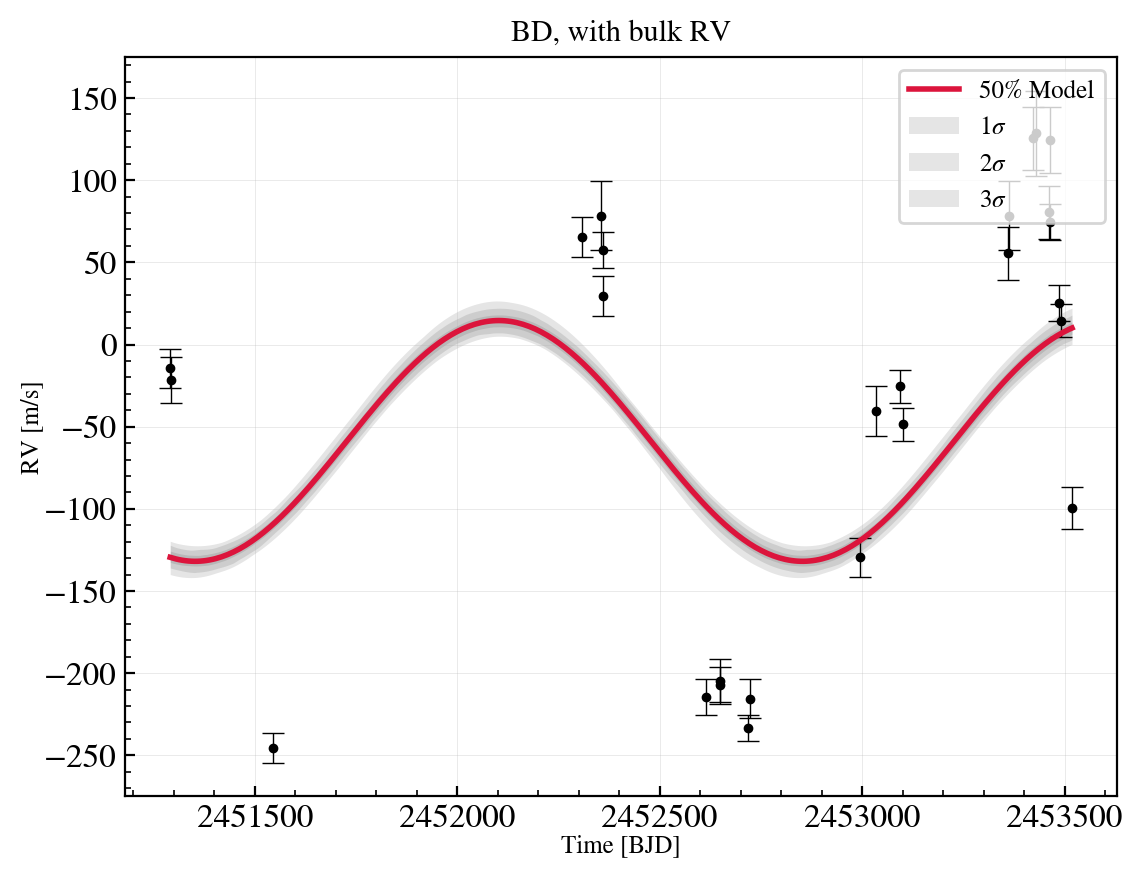

In [33]:
import ExoMUSE_utils
TITLE = 'BD, with bulk RV'
NUMMODELS = 400
shadecolor="black"

###################
times1 = np.linspace(TF.lpf.data['x'][0]-0.02,TF.lpf.data['x'][-1]+0.02,500)
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
t1_mod = np.linspace(times1.min()-0.02,times1.max()+0.02,300)
rv_50 = TF.lpf.compute_total_model(pv_50,t1_mod)

# Plot random samples
fig, ax = plt.subplots(dpi=200)

#################
# Plot data
#################
markercolor="black"
ax.errorbar(TF.lpf.data['x'],TF.lpf.data['y'],TF.lpf.data['error'],
            marker='o',elinewidth=0.5,capsize=4,lw=0,mew=0.5,color=markercolor,markersize=3)
ax.plot(t1_mod,rv_50,color="crimson",
        label=r'50% Model',lw=2.,zorder=10)

#################
# Sample models
#################
mmodel1 = []
for i in range(NUMMODELS):
    if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)
#################

ax.fill_between(t1_mod,np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='1$\sigma$',zorder=-1)
ax.fill_between(t1_mod,np.quantile(mmodel1,0.02,axis=0),np.quantile(mmodel1,0.98,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
ax.fill_between(t1_mod,np.quantile(mmodel1,0.0015,axis=0),np.quantile(mmodel1,0.9985,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)
ax.legend(loc='upper right')
ax.set_xlabel('Time [BJD]',labelpad=0)
ax.set_ylabel('RV [m/s]',labelpad=0)
ax.set_title(TITLE)
ExoMUSE_utils.ax_apply_settings(ax)

plt.savefig("rvastrometryexample.png", dpi = 500)

plt.show();

## Extras

In [27]:
df_post, df_mean = TF.calculate_derived_params(df_post)
df_post

,mstar,mp,ecc_p1,omega_p1,cosi,Omega,P_p1,tp_p1,plx,gamma,i,a0,K_p1,A,B,F,G
0,0.762002,59.999755,5.695896e-05,201.864852,0.998124,201.405967,1499.964098,499.947314,29.129969,-60.026793,3.509949,4.886628,74.488020,3.559307,3.346349,-3.346423,-4.878551
1,0.762002,59.999757,5.647124e-05,201.863133,0.998124,201.408052,1499.963992,499.947789,29.129969,-60.036229,3.510098,4.886628,74.491174,3.559286,3.346372,-3.346445,-4.878553
2,0.762002,59.999742,6.103369e-05,201.863198,0.998128,201.404226,1499.963727,499.948924,29.129968,-59.986736,3.506389,4.886626,74.412546,3.559501,3.346144,-3.346217,-4.878565
3,0.762002,59.999742,6.103369e-05,201.863198,0.998128,201.404226,1499.963727,499.948924,29.129968,-59.986736,3.506389,4.886626,74.412546,3.559501,3.346144,-3.346217,-4.878565
4,0.762001,59.999790,7.413375e-05,201.904107,0.998096,201.313723,1499.963919,499.948573,29.129964,-59.695918,3.536077,4.886633,75.041908,3.562423,3.343006,-3.343102,-4.878333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899995,0.762009,59.999941,1.451414e-07,202.119976,0.998091,201.363336,1499.967150,499.997372,29.129984,-58.046881,3.541215,4.886622,75.150415,3.546890,3.359424,-3.359548,-4.878146
3899996,0.762009,59.999941,1.451414e-07,202.119976,0.998091,201.363336,1499.967150,499.997372,29.129984,-58.046881,3.541215,4.886622,75.150415,3.546890,3.359424,-3.359548,-4.878146
3899997,0.762010,59.999978,1.050826e-07,202.142781,0.998057,201.357119,1499.967850,499.997987,29.129989,-58.037751,3.571981,4.886623,75.802465,3.545940,3.360391,-3.360521,-4.877975
3899998,0.762010,59.999964,1.756225e-06,202.079111,0.998071,201.398299,1499.967527,499.994530,29.129984,-57.975104,3.559125,4.886624,75.530013,3.547250,3.359033,-3.359145,-4.878147


In [28]:
df_mean[['Labels','values']]

,Labels,values
0,mstar,$0.7620022_{-0.000002}^{+0.000004}$
0,mp,$59.99989_{-0.00018}^{+0.00008}$
0,ecc_p1,$1.29e-05_{-0.000010}^{+0.00002}$
0,omega_p1,$201.77_{-0.12}^{+0.12}$
0,cosi,$0.99819_{-0.00013}^{+0.00012}$
0,Omega,$201.6_{-0.12}^{+0.12}$
0,P_p1,$1499.9655_{-0.0053}^{+0.0053}$
0,tp_p1,$499.986_{-0.023}^{+0.010}$
0,plx,$29.129947_{-0.00009}^{+0.00004}$
0,gamma,$-58.7_{-2.4}^{+2.4}$


In [29]:
TF.lpf.df_known

,label,median,error
0,A,0.195897,0.079865
1,B,-0.063934,0.040788
2,F,-0.324407,0.056696
3,G,-0.128140,0.042197
4,e,0.369314,0.149856
5,P,850.837877,112.527145
6,t_peri,145.677340,68.638020


In [30]:
TF.lpf.C

,a_thiele_innes,b_thiele_innes,f_thiele_innes,g_thiele_innes,eccentricity,period,t_periastron
a_thiele_innes,0.006378,0.001839,0.003520,-0.000948,0.001939,1.638565,-4.714584
b_thiele_innes,0.001839,0.001664,0.001301,0.000159,-0.000313,-0.168007,-1.515231
f_thiele_innes,0.003520,0.001301,0.003214,-0.000366,-0.002545,-1.950001,-1.862900
g_thiele_innes,-0.000948,0.000159,-0.000366,0.001781,-0.002993,-2.541454,1.257802
period,1.638565,-0.168007,-1.950001,-2.541454,14.179651,12662.358362,-4704.520361
eccentricity,0.001939,-0.000313,-0.002545,-0.002993,0.022457,14.179651,-5.081229
t_periastron,-4.714584,-1.515231,-1.862900,1.257802,-5.081229,-4704.520361,4711.177790


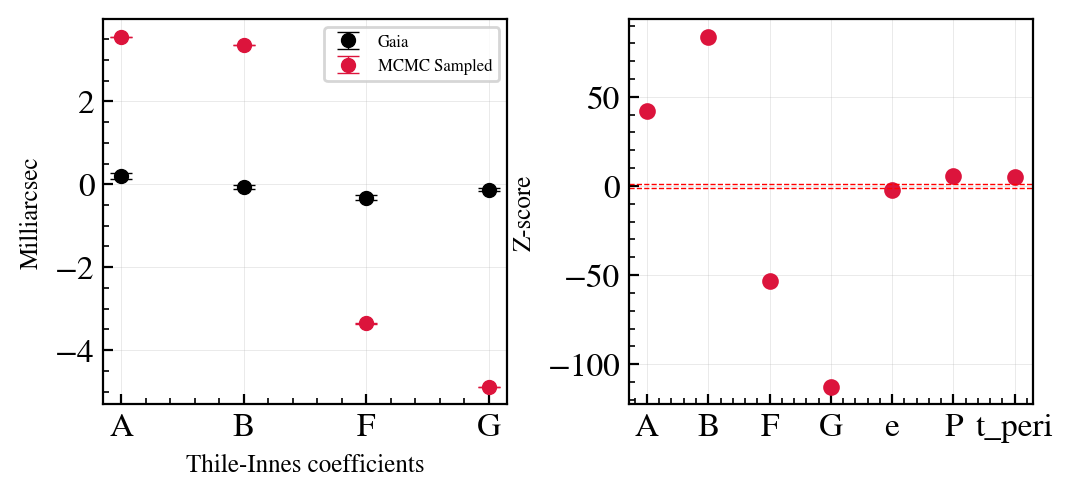

In [34]:
TF.plot_zscore_panel()
plt.show();